# $T_1$

In a $T_1$ experiment, we measure an excited qubit after a delay. Due to decoherence processes (e.g. amplitude damping channel), it is possible that, at the time of measurement, after the delay, the qubit will not be excited anymore. The larger the delay time is, the more likely is the qubit to fall to the ground state. The goal of the experiment is to characterize the decay rate of the qubit towards the ground state.

We start by fixing a delay time $t$ and a number of shots $s$. Then, by repeating $s$ times the procedure of exciting the qubit, waiting, and measuring, we estimate the probability to measure $|1\rangle$ after the delay. We repeat this process for a set of delay times, resulting in a set of probability estimates.

In the absence of state preparation and measurement errors, the probability to measure |1> after time $t$ is $e^{-t/T_1}$, for a constant $T_1$ (the coherence time), which is our target number. Since state preparation and measurement errors do exist, the qubit's decay towards the ground state assumes the form $Ae^{-t/T_1} + B$, for parameters $A, T_1$, and $B$, which we deduce form the probability estimates. To this end, the $T_1$ experiment internally calls the `curve_fit` method of `scipy.optimize`.

The following code demonstrates a basic run of a $T_1$ experiment for qubit 0.

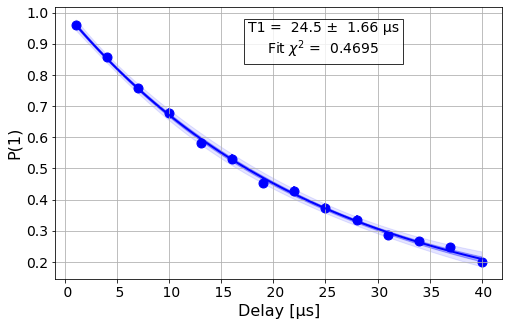

DbAnalysisResultV1
- name: @Parameters_T1Analysis
- value: [0.9821099040440951, 0.01798593147495241, 2.4474086198341437e-05]
- χ²: 0.4695279632801443
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T1
- value: 2.4474086198341437e-05 ± 1.6592814917067882e-06 s
- χ²: 0.4695279632801443
- quality: good
- device_components: ['Q0']
- verified: False


In [1]:
import numpy as np
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import T1

# A T1 simulator
from qiskit_experiments.test.t1_backend import T1Backend

# Simulate T1 of 25 microseconds using a mock backend
t1 = 25e-6
backend = T1Backend(t1=[t1])

# Time intervals to wait before measurement
delays = np.arange(1e-6, 40e-6, 3e-6)

# Create an experiment for qubit 0
# with the specified time intervals
exp = T1(qubit=0, delays=delays)

# Run the experiment circuits with 1000 shots each,
# and analyze the result
exp_data = exp.run(backend=backend, shots=1000).block_for_results()

# Print the result
display(exp_data.figure(0))
for result in exp_data.analysis_results():
    print(result)

## Parallel $T_1$ experiments on multiple qubits

To measure $T_1$ of multiple qubits in the same experiment, we create a parallel experiment:

In [2]:
# A simulator where qubits 0 and 1 have T1 of 25 microseconds
backend = T1Backend(t1=[t1, t1])

# An experiment for qubit 1
exp_q1 = T1(qubit=1, delays=delays)

# A parallel experiment
parallel_exp = ParallelExperiment([exp, exp_q1])
parallel_data = parallel_exp.run(backend).block_for_results()

# View result data
for result in parallel_data.analysis_results():
    print(result)

DbAnalysisResultV1
- name: T1
- value: 8ea7fd2c-3932-4ddd-9680-628d2ecf799f
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T1
- value: d05e4dd4-a473-4d66-b715-bfa741a19208
- device_components: ['Q1']
- verified: False


### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `child_data`

Component experiment 0


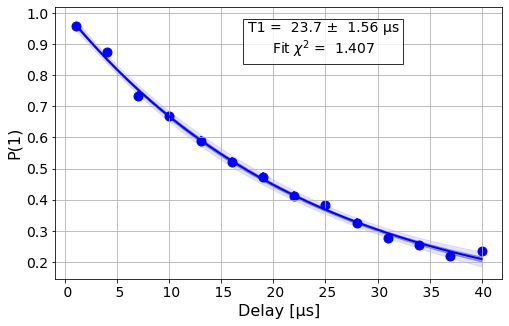

DbAnalysisResultV1
- name: @Parameters_T1Analysis
- value: [0.9723929796037107, 0.030079101576933994, 2.365743625940359e-05]
- χ²: 1.4066092735634719
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T1
- value: 2.365743625940359e-05 ± 1.5560579006080807e-06 s
- χ²: 1.4066092735634719
- quality: good
- device_components: ['Q0']
- verified: False
Component experiment 1


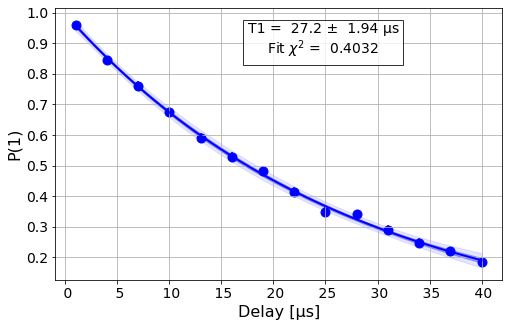

DbAnalysisResultV1
- name: @Parameters_T1Analysis
- value: [1.0448015320681805, -0.04986905355381349, 2.724026205010881e-05]
- χ²: 0.40324395180304334
- quality: good
- extra: <4 items>
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: T1
- value: 2.724026205010881e-05 ± 1.9434552221939893e-06 s
- χ²: 0.40324395180304334
- quality: good
- device_components: ['Q1']
- verified: False


In [3]:
# Print sub-experiment data
for i, sub_data in enumerate(parallel_data.child_data()):
    print(f"Component experiment {i}")
    display(sub_data.figure(0))
    for result in sub_data.analysis_results():
        print(result)

In [4]:
import qiskit.tools.jupyter
%qiskit_copyright